# Simulate PTA with PTA-replicator and Enterprise

In [1]:
from pta_replicator_main.pta_replicator.simulate import load_from_directories
from pta_replicator_main.pta_replicator.simulate import make_ideal
from pta_replicator_main.pta_replicator.white_noise import add_measurement_noise
from pta_replicator_main.pta_replicator.red_noise import add_red_noise, add_gwb
from pta_replicator_main.pta_replicator.deterministic import add_cgw

from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import selections
from enterprise.signals import gp_signals
from enterprise.signals import gp_priors
from enterprise.signals import signal_base
from enterprise.signals import deterministic_signals
from enterprise.signals.utils import hd_orf
from enterprise.signals import utils
from enterprise_extensions.deterministic import cw_block_circ

import pickle
import dill
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from random import sample, seed

import params_injected
from pulsar_phase import get_psr_phase

%load_ext autoreload
%autoreload 2

## Simulate pulsars

In [2]:
pardir = 'partim/par'
timdir = 'partim/tim'
num_psrs = params_injected.num_psrs
# psrs = load_from_directories(pardir, timdir, num_psrs=num_psrs)
psrs_full = load_from_directories(pardir, timdir, num_psrs=50)
# seed(0)
seed(14)
psrs = sample(psrs_full, k=num_psrs)

2025-08-28 13:36:07.764 | DEBUG    | pint.toa:__init__:1358 - No pulse number flags found in the TOAs
2025-08-28 13:36:07.767 | DEBUG    | pint.toa:apply_clock_corrections:2200 - Applying clock corrections (include_gps = True, include_bipm = True)
2025-08-28 13:36:07.787 | INFO     | pint.observatory:gps_correction:210 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-08-28 13:36:07.788 | INFO     | pint.observatory:_load_gps_clock:92 - Loading global GPS clock file
2025-08-28 13:36:07.796 | DEBUG    | pint.observatory.clock_file:__init__:799 - Global clock file gps2utc.clk saving kwargs={'bogus_last_correction': False, 'valid_beyond_ends': False}
2025-08-28 13:36:07.803 | DEBUG    | pint.observatory.clock_file:read_tempo2_clock_file:456 - Loading TEMPO2-format observatory clock correction file gps2utc.clk (/Users/aidengundersen/.astropy/cache/download/url/d3c81b5766f4bfb84e65504c8a453085/contents) with bogus_last_correction=False
2025-08-28 13:36:07.844 | INFO     | pint.

In [3]:
# store injected parameters
x_inj = {}

# add signals and noise
psr_phases = np.zeros(num_psrs)
for ii, psr in enumerate(psrs):

    ## make ideal
    make_ideal(psr)

    # add efacs
    ## if you use flags, the flags and efac and equad values all need to have the same number of elements
    add_measurement_noise(psr,
                          efac=params_injected.efac_inj, 
                          seed=params_injected.efac_seed + ii)

    ## add red noise
    if params_injected.rn_model:
        add_red_noise(psr,
                      log10_amplitude=params_injected.RN_logamps_inj[ii],
                      spectral_index=params_injected.RN_gammas_inj[ii],
                      components=params_injected.num_modes,
                      seed=params_injected.RN_seed + ii)
        x_inj[f'{psr.name}_red_noise_log10_A'] = params_injected.RN_logamps_inj[ii]
        x_inj[f'{psr.name}_red_noise_gamma'] = params_injected.RN_gammas_inj[ii]
    
    ## add continuous wave
    if params_injected.cw_model:
        ent_psr = psr.to_enterprise()
        psr_dist = ent_psr.pdist[0]
        psr_phase = get_psr_phase(params_injected.CW_params_inj, ent_psr.pos, psr_dist)
        psr_phases[ii] = psr_phase
        psr_params = np.array([psr_dist, psr_phase])
        add_cgw(psr, params_injected.CW_params_inj, psr_params, ent_psr.toas, ent_psr.pos)
        x_inj[f'{psr.name}_cw_p_dist'] = psr_dist
        x_inj[f'{psr.name}_cw_p_phase'] = psr_phase 

    print(ii, psr.name)

# add common CW parameters
if params_injected.cw_model:
    x_inj['cw_cosinc'] = params_injected.cosinc_inj
    x_inj['cw_costheta'] = params_injected.costheta_inj
    x_inj['cw_log10_Mc'] = params_injected.log10_mc_inj
    x_inj['cw_log10_dL'] = params_injected.log10_dist_inj
    x_inj['cw_log10_fgw'] = params_injected.log10_fgw_inj
    x_inj['cw_phase0'] = params_injected.phase0_inj
    x_inj['cw_phi'] = params_injected.gwphi_inj
    x_inj['cw_psi'] = params_injected.psi_inj

2025-08-28 13:36:31.990 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-08-28 13:36:31.992 | DEBUG    | pint.toa:compute_TDBs:2253 - tdb column already exists. Deleting...
2025-08-28 13:36:31.996 | DEBUG    | pint.toa:compute_TDBs:2256 - tdbld column already exists. Deleting...
2025-08-28 13:36:32.000 | DEBUG    | pint.toa:compute_TDBs:2272 - Using EPHEM = DE440 for TDB calculation.
2025-08-28 13:36:32.043 | DEBUG    | pint.toa:compute_posvels:2345 - Computing PosVels of observatories, Earth and planets, using DE440
2025-08-28 13:36:32.045 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_pos already exists. Removing...
2025-08-28 13:36:32.046 | DEBUG    | pint.toa:compute_posvels:2355 - Column ssb_obs_vel already exists. Removing...
2025-08-28 13:36:32.047 | DEBUG    | pint.toa:compute_posvels:2355 - Column obs_sun_pos already exists. Removing...
2025-08-28 13:36:32.048 | DEBUG    | pint.toa:compute_posvels:2360 - Column obs_jupiter_pos already exists. 

0 J0406+3039


2025-08-28 13:36:34.470 | DEBUG    | pint.toa:compute_posvels:2403 - SSB obs pos [-3.87409706e+09  1.34555717e+11  5.83294451e+10] m
2025-08-28 13:36:34.473 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:34.478 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:34.481 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:34.484 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:34.487 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:34.489 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:34.491 | INFO     | pint.sol

1 J1745+1017


2025-08-28 13:36:36.917 | DEBUG    | pint.toa:compute_posvels:2403 - SSB obs pos [-3.87409705e+09  1.34555717e+11  5.83294451e+10] m
2025-08-28 13:36:36.919 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:36.922 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:36.923 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:36.927 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:36.930 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:36.931 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:36.935 | INFO     | pint.sol

2 J1832-0836


2025-08-28 13:36:39.430 | DEBUG    | pint.toa:compute_posvels:2403 - SSB obs pos [-3.87409705e+09  1.34555717e+11  5.83294451e+10] m
2025-08-28 13:36:39.431 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:39.434 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:39.444 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:39.451 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:39.460 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:39.467 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:39.471 | INFO     | pint.sol

3 J1909-3744


2025-08-28 13:36:41.873 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:41.874 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:41.877 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:41.880 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:41.881 | INFO     | pint.solar_system_ephemerides:load_kernel:127 - Set solar system ephemeris to de440 through astropy
2025-08-28 13:36:41.887 | DEBUG    | pint.toa:compute_posvels:2417 - Adding columns ssb_obs_pos ssb_obs_vel obs_sun_pos obs_jupiter_pos obs_saturn_pos obs_venus_pos obs_uranus_pos obs_neptune_pos obs_earth_pos
2025-08-28 13:36:42.029 | DEBUG    | pint.toa:compute_TDBs:2251 - Computing TDB columns.
2025-08-28 13:36

4 J1751-2857


In [4]:
if params_injected.gwb_model:
        add_gwb(psrs,
                log10_amplitude=params_injected.GWB_logamp_inj,
                spectral_index=params_injected.GWB_gamma_inj,
                seed=params_injected.GWB_seed)
        x_inj['log10_A_gw'] = params_injected.GWB_logamp_inj
        x_inj['gamma_gw'] = params_injected.GWB_gamma_inj

In [5]:
# fit timing model
for psr in psrs:
    print(psr.name)
    psr.fit()

2025-08-28 13:36:44.123 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J0406+3039


2025-08-28 13:36:45.578 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.0010584036076011216
2025-08-28 13:36:45.699 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1745+1017


2025-08-28 13:36:47.284 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.003497554225120325
2025-08-28 13:36:47.407 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1832-0836


2025-08-28 13:36:48.962 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.0018970162137179614
2025-08-28 13:36:49.628 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1909-3744


2025-08-28 13:36:51.172 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: -0.0003102265451069286
2025-08-28 13:36:51.287 | INFO     | pint.fitter:auto:313 - For narrowband TOAs without correlated errors and downhill fitter, returning 'DownhillWLSFitter'


J1751-2857


2025-08-28 13:36:52.814 | DEBUG    | pint.fitter:_fit_toas:1233 - Iteration 1: chi2 does not improve, stopping; decrease: 0.003580088500688916


J0406+3039


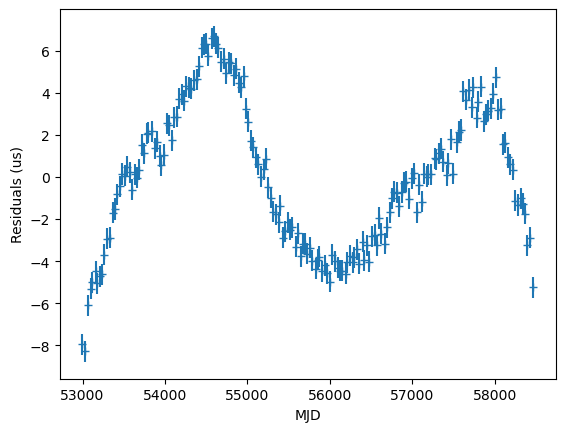

J1745+1017


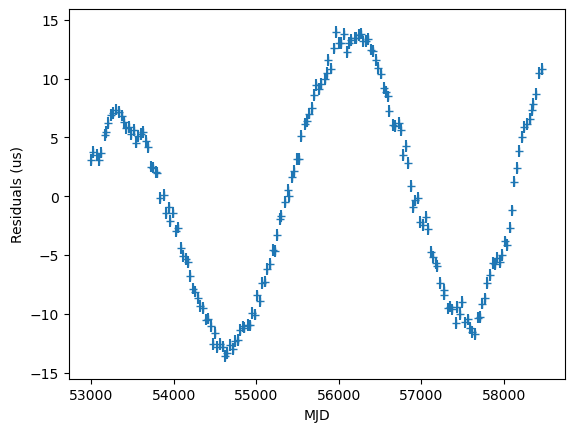

J1832-0836


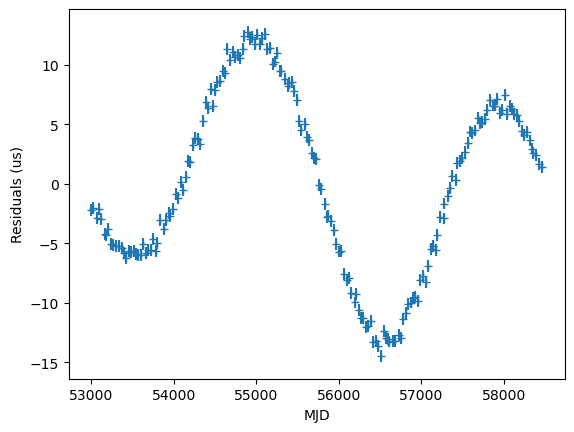

J1909-3744


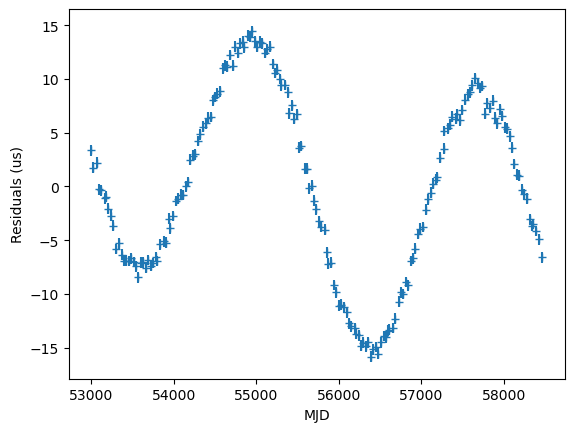

J1751-2857


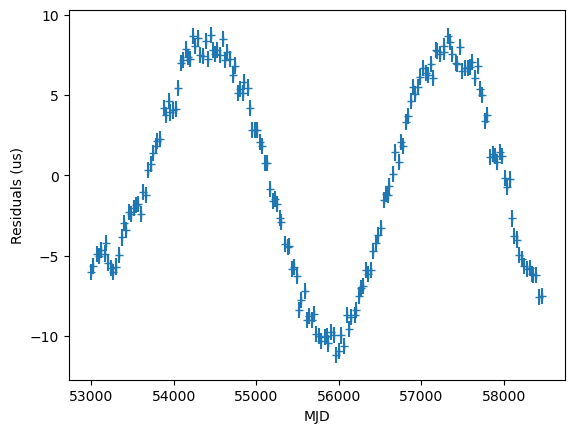

In [6]:
for psr in psrs:
    print(psr.name)
    plt.errorbar(
        psr.toas.get_mjds(),
        psr.residuals.time_resids.to_value("us"),
        psr.residuals.get_data_error().to_value("us"),
        marker="+",
        ls="",
    )
    plt.xlabel("MJD")
    plt.ylabel("Residuals (us)")
    plt.show()

In [7]:
# convert to enterprise type pulsars
ent_psrs = []
for psr in psrs:
    ent_psrs.append(psr.to_enterprise())

2025-08-28 13:36:55.881 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.
2025-08-28 13:36:56.909 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.
2025-08-28 13:36:57.725 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.
2025-08-28 13:36:58.614 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.
2025-08-28 13:36:59.507 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:860 - ECL not specified; using IERS2010.


In [8]:
# save Enterprise pulsar objects
with open('data/enterprise_pulsars.pkl', 'wb') as f:
    pickle.dump(ent_psrs, f)

In [9]:
for psr in ent_psrs:
    print(psr.pdist)

(1.0, 0.2)
(1.0, 0.2)
(1.0, 0.2)
(1.26, 0.03)
(1.0, 0.2)


## Make PTA

In [10]:
# use built in backend selection
backend = selections.Selection(selections.by_backend)

# EFAC parameter
if params_injected.wn_model:
    efac_param = parameter.Uniform(0.5, 3.0)
else:
    efac_param = params_injected.efac_inj

# make white noise
wn = white_signals.MeasurementNoise(efac=efac_param,
                                    log10_t2equad=-1000, 
                                    selection=backend)

In [11]:
# red noise
if params_injected.rn_model:
    logamp_param = parameter.Uniform(-30., -10.)
    gamma_param = parameter.Uniform(0.1, 20.)

    # get power law in prior
    powlaw = gp_priors.powerlaw(log10_A=logamp_param, gamma=gamma_param)

    # make red noise
    rn = gp_signals.FourierBasisGP(spectrum=powlaw, components=params_injected.num_modes)

In [12]:
# GWB
if params_injected.gwb_model:
    log10_A_gw = parameter.Uniform(-30., -10.)('log10_A_gw')
    gamma_gw = parameter.Uniform(0.1, 20.)('gamma_gw')
    cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
    gw = gp_signals.FourierBasisCommonGP(spectrum=cpl, orf=hd_orf(),
                                         components=params_injected.num_modes, name='gw')

In [13]:
# make CW signal
if params_injected.cw_model:
    cw = cw_block_circ(dist_prior='log-uniform', psrTerm=True, tref=params_injected.tref)

In [14]:
# make timing model
tm = gp_signals.TimingModel(use_svd=True)

In [15]:
# make model and PTA object
model = tm + wn
if params_injected.rn_model:
    model += rn
if params_injected.gwb_model:
    model += gw
if params_injected.cw_model:
    model += cw
    
pta = signal_base.PTA([model(psr) for psr in ent_psrs])

In [16]:
# save PTA object
with open('data/pta.pkl', 'wb') as f:
    dill.dump(pta, f)

print(pta.summary())

enterprise v3.3.3,  Python v3.10.14

Signal Name                              Signal Class                   no. Parameters      
J0406+3039_linear_timing_model_svd       TimingModel                    0                   

params:
__________________________________________________________________________________________
J0406+3039_measurement_noise             MeasurementNoise               0                   

params:
__________________________________________________________________________________________
J0406+3039_red_noise                     FourierBasisGP                 2                   

params:
J0406+3039_red_noise_log10_A:Uniform(pmin=-30.0, pmax=-10.0)                              
J0406+3039_red_noise_gamma:Uniform(pmin=0.1, pmax=20.0)                                   
__________________________________________________________________________________________
J0406+3039_cw                            CWSignal                       10                  

params:
cw_cost

In [17]:
# save data
Fs = np.array([basis[:, 8:] for basis in pta.get_basis()])
Ms = np.array([ent_psr.Mmat for ent_psr in ent_psrs])
Ns = np.array([np.diag(ent_psr.toaerrs**2.) for ent_psr in ent_psrs])
toas = np.array([ent_psr.toas for ent_psr in ent_psrs])
residuals = np.array([ent_psr.residuals for ent_psr in ent_psrs])
psr_pos = np.array([ent_psr.pos for ent_psr in ent_psrs])
psr_names = np.array([ent_psr.name for ent_psr in ent_psrs])
psr_dists = np.array([[psr.pdist[0], psr.pdist[1]] for psr in ent_psrs]).T

# save data in dictionary
data_dict = {}
data_dict['Fs'] = Fs
data_dict['Ms'] = Ms
data_dict['Ns'] = Ns
data_dict['toas'] = toas
data_dict['residuals'] = residuals
data_dict['psr_pos'] = psr_pos
data_dict['psr_names'] = psr_names
data_dict['psr_dists'] = psr_dists
data_dict['psr_phases'] = psr_phases
data_dict['x_inj'] = x_inj
np.savez_compressed('data/data_dict.npz', **data_dict)

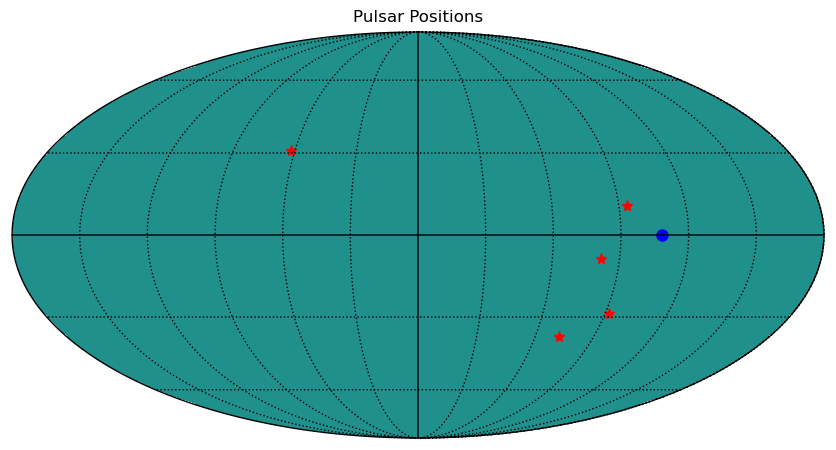

In [18]:
# plot pulsar positions
theta_psr = np.arccos(psr_pos[:, 2])  # z = cos(theta)
phi_psr = np.arctan2(psr_pos[:, 1], psr_pos[:, 0])  # atan2(y, x)
phi_psr = np.mod(phi_psr, 2 * np.pi)


# Convert to HEALPix map
nside = 64
npix = hp.nside2npix(nside)

# Plot
hp.mollview(np.zeros(hp.nside2npix(64)), title="Pulsar Positions", cbar=False)
hp.projplot(theta_psr, phi_psr, 'r*', markersize=8)
hp.projplot(params_injected.gwtheta_inj, params_injected.gwphi_inj, 'bo', markersize=8)
hp.graticule()
plt.show()